In [0]:
# !apt-get install -y -qq software-properties-common module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth 
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials 
# creds = GoogleCredentials.get_application_default()
# import getpass 
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass() 
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# !mkdir -p drive
# !google-drive-ocamlfuse drive
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [0]:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# file_id = "1O_OaVO8D6G065vMjQSr649hk2G6yErD0"
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('15k_games.csv')  

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import math
import pprint
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

# Preprocessing

In [3]:
df = pd.DataFrame({})
X_col_idxs = range(768)
dtypes = {idx: 'int8' for idx in X_col_idxs} #set dtypes beforehand to save memory
dtypes[768] = 'str'

df = pd.read_csv('gdrive/My Drive/Colab Notebooks/chess_ANN/15k_games.csv', 
                 sep=",", header=None, dtype=dtypes, memory_map=True)
display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768
0,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,23.0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,-23.0
2,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,15.0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,-18.0
4,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,16.0


### Split into Features (X) and Response (y); Plot Response Histogram

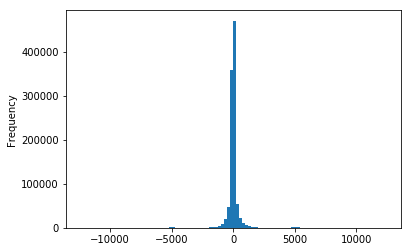

In [4]:
features = df.iloc[:,:-1]
response = df.iloc[:,-1].astype(float)

response.plot(kind='hist', bins=100)
plt.show()

### Train / Test Split; MinMax Normalization

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3)

min_ = min(y_train)
max_ = max(y_train)
range_ = max_ - min_

y_train = y_train.apply(lambda x: (x-min_)/(range_))
y_test = y_test.apply(lambda x: (x-min_)/(range_))

## MLP Trained with TPU Accelerator

In [6]:
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
    TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
    TF_MASTER=''

with tf.Session(TF_MASTER) as session:
    print ('List of devices:')
    pprint.pprint(session.list_devices())

List of devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 16407003043136730563),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9068286254732628876),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11937760377172194291),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14677259097826955029),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12743713927359199936),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11425240918789206936),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 13359991103193017768),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 7980387815208977986),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 11267015293825796762),
 _DeviceAttributes(/job

In [19]:
def get_model():
    return keras.Sequential([
        keras.layers.Dense(2048, input_dim=768, activation=tf.nn.elu),
        keras.layers.Dense(2048, activation=tf.nn.elu),
        keras.layers.Dense(2048, activation=tf.nn.elu),
        keras.layers.Dense(1)
    ])

model = get_model()
model.summary()
model.compile(optimizer=tf.train.GradientDescentOptimizer(.001),
             loss='mean_squared_error',
             metrics=['mean_squared_error'],
             epsilon = 0.00000001,
             nesterov=0.7)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2048)              1574912   
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2049      
Total params: 9,969,665
Trainable params: 9,969,665
Non-trainable params: 0
_________________________________________________________________


In [20]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TF_MASTER)))

history = tpu_model.fit(X_train, y_train, epochs=10, batch_size=256)
tpu_model.save_weights('model_weights.h5', overwrite=True)

INFO:tensorflow:Querying Tensorflow master (grpc://10.56.28.170:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 16407003043136730563)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9068286254732628876)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11937760377172194291)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14677259097826955029)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12743713927359199936)
INFO:tensorflow:*** Available Device: _DeviceAttribute

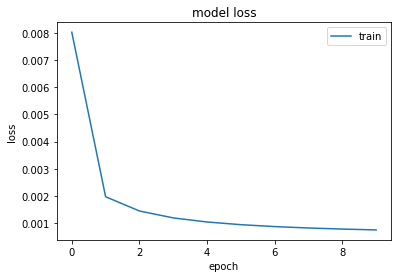

In [9]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [10]:
prediction_model = get_model()
prediction_model.load_weights('/tmp/weights.h5')

y_pred = prediction_model.predict(X_test)

# fix the data structure of y_pred before doing these
print('The RMSE is: ' + str(sqrt(mean_squared_error(y_test.values, y_pred[:,0]))))
print('The Mean Absolute Error is: ' + str(mean_absolute_error(y_test.values, y_pred[:,0])))
print('The Median Absolute Error is: ' + str(median_absolute_error(y_test.values, y_pred[:,0])))

The RMSE squared is: 0.027312214481420634
The Mean Absolute Error is: 0.015326813953183204
The Median Absolute Error is: 0.009948693294039024


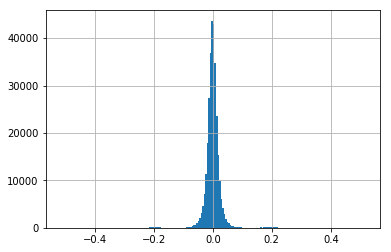

In [11]:
residuals = pd.Series(y_test.values - y_pred[:,0])
residuals.hist(bins=200);

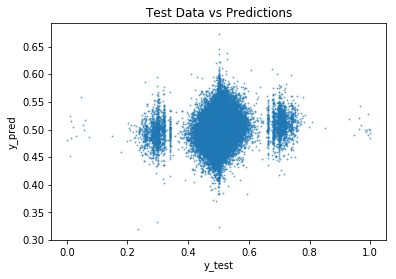

In [12]:
plt.scatter(y_test, y_pred, s=1, alpha=0.5);
plt.title('Test Data vs Predictions')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

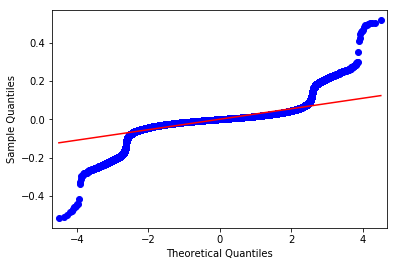

In [13]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='s');